## 导入所需库

In [20]:
from __future__ import print_function
import numpy as np
import keras
from keras.models import load_model
from keras.datasets import mnist
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import glob
import pydot

IMG_SIZE = 221
#LABEL_SIZE = 128
#epochs = 60

training_data_path = r'/floyd/input/architectural_style_classification'
num_classes = 6
model_name = 'keras_cnn_architecture.h5'
model_path_to_save = '.'

## 导入图片文件

In [21]:
pkg_names = os.listdir(training_data_path)
m_tr_pkgs = len(pkg_names)
target = []
img_buff = np.zeros((300, IMG_SIZE, IMG_SIZE, 3))
for m in range(m_tr_pkgs):
    img_names = os.listdir(training_data_path + '/' + pkg_names[m])
    m_tr_imgs = len(os.listdir(training_data_path + '/' + pkg_names[m]))
    for i in range(m_tr_imgs):
        img_file_path = os.path.join(training_data_path + '/' + pkg_names[m] + '/' + img_names[i])
        img = cv2.imread(img_file_path)
        img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
        img_buff[50*m+i, :, :, :] = img/255.
        this_label = pkg_names[m]
        target.append(this_label)

        if np.mod(i, 5) == 1:
            print('reading images: ' + str(i) + ' / ' + str(m_tr_imgs))

reading images: 1 / 50
reading images: 6 / 50
reading images: 11 / 50
reading images: 16 / 50
reading images: 21 / 50
reading images: 26 / 50
reading images: 31 / 50
reading images: 36 / 50
reading images: 41 / 50
reading images: 46 / 50
reading images: 1 / 50
reading images: 6 / 50
reading images: 11 / 50
reading images: 16 / 50
reading images: 21 / 50
reading images: 26 / 50
reading images: 31 / 50
reading images: 36 / 50
reading images: 41 / 50
reading images: 46 / 50
reading images: 1 / 50
reading images: 6 / 50
reading images: 11 / 50
reading images: 16 / 50
reading images: 21 / 50
reading images: 26 / 50
reading images: 31 / 50
reading images: 36 / 50
reading images: 41 / 50
reading images: 46 / 50
reading images: 1 / 50
reading images: 6 / 50
reading images: 11 / 50
reading images: 16 / 50
reading images: 21 / 50
reading images: 26 / 50
reading images: 31 / 50
reading images: 36 / 50
reading images: 41 / 50
reading images: 46 / 50
reading images: 1 / 50
reading images: 6 / 50
re

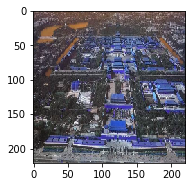

In [22]:
for i in range(49):
    plt.subplot(1,2,1)
    plt.imshow(img_buff[i, :])

In [23]:
img_buff[0].shape

(221, 221, 3)

In [24]:
target[49]

'Jing'

## 分类训练集和测试集

In [25]:
classes = ['Chuan', 'Hui', 'Jin', 'Jing', 'Min', 'Su']
for i in range(len(target)):
    target[i] = classes.index(target[i])

In [26]:
# the data, split between train and test sets
x_train, x_test, y_train, y_test = train_test_split(img_buff, target, test_size=0.2)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## 搭建模型

In [27]:
x_train.shape

(240, 221, 221, 3)

In [28]:
from keras.applications import DenseNet121

In [30]:
densenet = DenseNet121(
    weights= 'imagenet',
    include_top=False,
    input_shape=x_train.shape[1:]
)

30015488/30011760 [==============================] - 2s 0us/step


In [32]:
model = Sequential()
model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


## 训练模型

In [34]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [35]:
from keras.callbacks import Callback

def evaluate(): # 评测函数
    pred = model.predict(x_test)
    return np.mean(pred.argmax(axis=1) == y_test) # 爱算啥就算啥


# 定义Callback器，计算验证集的acc，并保存最优模型
class Evaluate(Callback):

    def __init__(self):
        self.accs = []
        self.highest = 0.

    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate()
        self.accs.append(acc)
        if acc >= self.highest: # 保存最优模型权重
            self.highest = acc
            model.save_weights('best_model.weights')



evaluator = Evaluate()

In [36]:
with_augmentation = True

In [37]:
if with_augmentation == False:
    model2.fit(x_train, y_train,
          epochs=60,
          batch_size=100,
          validation_data=(x_test, y_test))
          
if with_augmentation == True:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.15,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.15,
        shear_range=0.5, # set range for random shear
        zoom_range=0.5, # set range for random zoom
        channel_shift_range=0.1,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
        
    datagen.fit(x_train)


In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=40),
                        epochs=30,
                        validation_data=(x_test, y_test),
                        steps_per_epoch=60,
                        callbacks=[evaluator])
score = model.evaluate(x_test, y_test, batch_size=30)

Epoch 1/30
42/60 [====================>.........] - ETA: 34s - loss: 0.5029 - acc: 0.8369